# Tuning and divergences in PyMC

To complete our understanding of how sampling works with Hamiltonian Monte Carlo algorithms, including the No-U-Turn sampler in PyMC, we have to understand the interplay between the tuned parameters of the sampler and the geometry of the posterior distribution. This knowledge will help us understand the PyMC error messages and correct the problems they describe.

**Run all cells** so the plots and results below are generated while you read.

## Prep plan

* There are 2 required readings, which should take ~45 minutes in total. There are also 2 optional readings that will require more time.
* Most of your time should be spent on working through the code in this workbook, experimenting with tuning and fixing divergences in the PyMC model provided below.

## Tuning the NUTS parameters

For the most part, we don't really need to think about tuning in PyMC. The sampler runs, tunes its parameters automatically, and generates samples from the target distribution for you. Tuning becomes important when we run into sampling problems — when $\widehat{R} > 1.01$, or the effective sample size is small (less than 10% of the actual number of samples), or we encounter divergences.

One way to try and fix these problems is to adjust how the sampler is tuned. But first, we need to understand which parameters are tuned and how tuning works normally.

### Readings

* Carroll, C. (n.d.). [Pragmatic Probabilistic Programming: Parameter Adaptation in PyMC3](https://colcarroll.github.io/hmc_tuning_talk/). (2,150 words).

This is a great blog post that synthesizes the concepts and algorithms we studied in the past 3 sessions. After reviewing and visualizing (watch all the videos!) how the Metropolis-Hastings and Hamiltonian Monte Carlo algorithms work, this post also explains how tuning works in PyMC.
  
In the No-U-Turn sampler, two parameters are optimized — the step size used to simulate the motion of a particle on the target distribution, and the covariance matrix of the Multivariate Normal distribution that is used to sample a new momentum (or, proportionally, speed) at the start of generating each new Hamiltonian path. You should understand the importance of each of these parameters and how they are tuned by the end of this article.
  
Some jargon to be aware of: Stationary distribution = target distribution = the probability distribution from which we want to generate samples, often the posterior distribution of a statistical model.

* (Optional) Carroll, C. (2019, April 21). [Step Size Adaptation in Hamiltonian Monte Carlo](https://colindcarroll.com/blog/step_size_adapt_hmc.html). (1,300 words)

If you would like a little more insight into how step sizes are tuned, read this article by the same author as above. It doesn't provide much more intuition than you already have but it does explain the existence of the `target_accept` (target acceptance rate) parameter in the sampler.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd

In [3]:
# You don't have to read through this function. Its purpose is to produce
# a contour plot of a 2-dimensional slice through a high-dimensional
# distribution. This function handles the messy details needed to produce
# the various contour plots in this workbook.

def plot_two_parameter_log_posterior(model, variable_params, fixed_params=None,
                                     plot_kind='contour', contour_kwargs=None,
                                     threed_kwargs=None):
    '''
    Inputs:

        model (pymc.Model) The model for which to produce a contour plot.

        variable_params (list of [str, array]) The two variables for which
          to produce the contour plot. These must be two variables listed
          in `model.value_vars`. Variable names can contain indices, for example
          "theta[1]" will plot the second entry in the theta parameter array.
          Provide the string name and a NumPy array of values for each variable.

        fixed_params (dict) This dictionary maps from each of the remaining
          variables in the model (not in `variable_params`) to fixed values.
          The contour plot will keep the values of these variables fixed and
          vary the values of the variables in `variable_params`. The dict maps
          from variable names to their values. Array variables must map to
          an array of values of the correct length. Scalar variables must map
          to scalar values.

        plot_kind (str) This is "contour", "3d", or "both", indicating which
          type of plot to produce.

        contour_kwargs (dict) Keyword arguments to pass on to the contour
          plotting function.

        threed_kwargs (dict) Keyword arguments to pass on to the 3d plotting
          function.
    '''
    if plot_kind not in ['contour', '3d', 'both']:
        raise ValueError("plot_kind must be 'contour' or '3d' or 'both'")

    # Check if any of the variable parameters contain indexes and parse them
    var_names = []
    var_indexes = []
    var_ranges = []
    for var_name, var_range in variable_params:
        if var_name.endswith(']'):
            pos = var_name.find('[')
            assert pos != -1
            var_index = int(var_name[pos+1:-1])
            var_name = var_name[:pos]
        else:
            var_index = None
        var_names.append(var_name)
        var_indexes.append(var_index)
        var_ranges.append(var_range)

    # Set up the log posterior density function and array of values for the
    # contour/3d plot.
    logp = model.compile_logp()
    log_prob_values = np.empty((len(var_ranges[1]), len(var_ranges[0])))
    point = dict(fixed_params or {})
    for i, var1_value in enumerate(var_ranges[0]):
        if var_indexes[0] is not None:
            point[var_names[0]][var_indexes[0]] = var1_value
        else:
            point[var_names[0]] = var1_value
        for j, var2_value in enumerate(var_ranges[1]):
            if var_indexes[1] is not None:
                point[var_names[1]][var_indexes[1]] = var2_value
            else:
                point[var_names[1]] = var2_value
            log_prob_values[j, i] = logp(point)

    if plot_kind in ('contour', 'both'):
        # Make a contour plot
        plt.figure(figsize=(7, 6))
        plt.title(f'Contour plot of unnormalized log posterior density')
        plt.contour(var_ranges[0], var_ranges[1], log_prob_values, **(contour_kwargs or {}))
        plt.colorbar()
        plt.xlabel(variable_params[0][0])
        plt.ylabel(variable_params[1][0])

    if plot_kind in ('3d', 'both'):
        # Make a 3d plot
        from matplotlib import cm
        fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": "3d"})
        plt.title(f'3d plot of unnormalized log posterior density')
        surf = ax.plot_surface(
            *np.meshgrid(var_ranges[0], var_ranges[1]), log_prob_values,
            cmap=cm.viridis, **(threed_kwargs or {}))
        plt.xlabel(variable_params[0][0])
        plt.ylabel(variable_params[1][0])

## Model: The devil's funnel

For the first part of the pre-class work, we will use a simple toy model introduced previously. To refresh your memory, the _devil's funnel_ model trips up samplers unless we separate out the $z$ and $v$ parameters below.

$$v \sim \text{Normal}(0, 3^2)$$
$$x \sim \text{Normal}(0, (e^v)^2)$$

This version of the model is difficult to sample from due to the high curvature of the posterior.

**Run the code cell below** to see this.

* Note that the color bar is on a logarithmic scale which means those slopes are _extremely_ steep. This messes up the particle motion simulation of the sampler.

Model variables: [v, x]


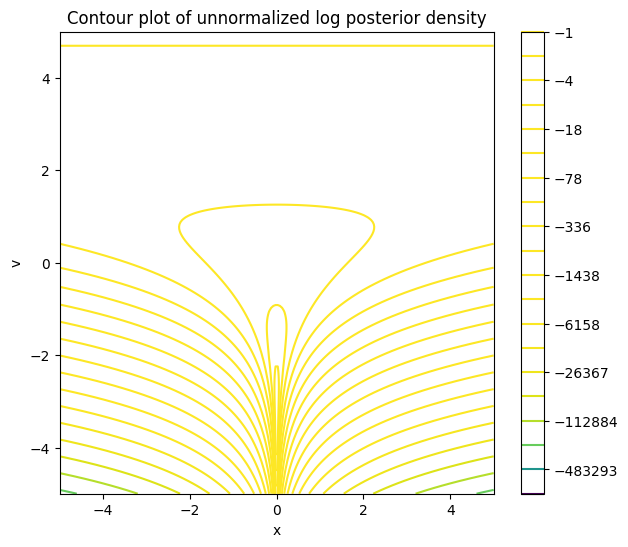

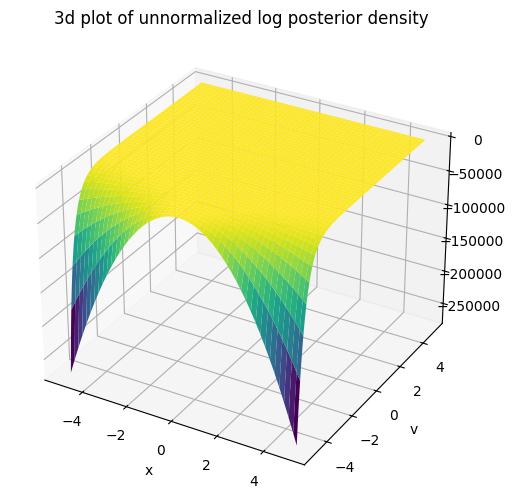

In [4]:
with pm.Model() as devils_funnel:
    v = pm.Normal('v', mu=0, sigma=3)
    x = pm.Normal('x', mu=0, sigma=pm.math.exp(v))

print('Model variables:', devils_funnel.value_vars)

plot_two_parameter_log_posterior(
    devils_funnel, [('x', np.linspace(-5, 5, 200)), ('v', np.linspace(-5, 5, 200))],
    contour_kwargs={'levels': -np.logspace(0, 6, 20)[::-1]}, plot_kind='both')

plt.show()

The key step to taming the devil's funnel was to go from the original model to this equivalent model where we first generate a standard Normal r.v. and then transform it to an r.v. equivalent to $x$ above.

$$v \sim \text{Normal}(0, 3^2)$$
$$z \sim \text{Normal}(0, 1^2)$$
$$x := z\,e^v$$

This version of the model is well-behaved and will not cause divergences.

**Run the code cell below**.

* This time the color bar has a linear scale and still the contours are evenly-spaced. This posterior has a nice even geometry/curvature making it easy to run the sampler's particle simulation.

Model variables: [v, z]


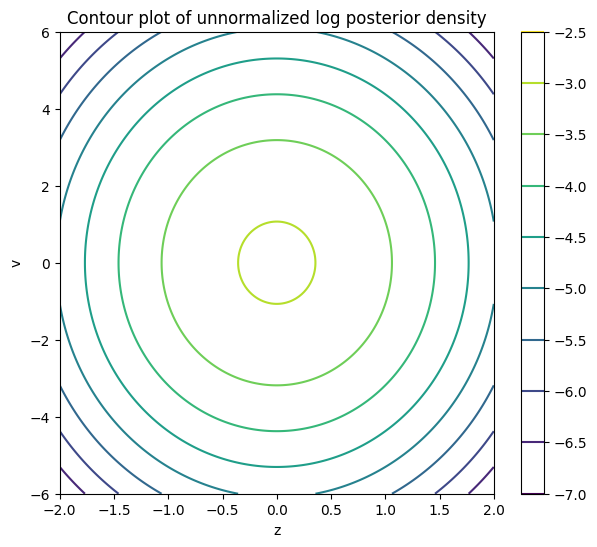

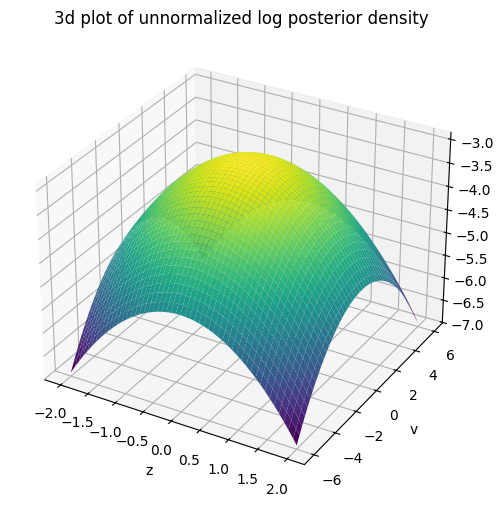

In [5]:
with pm.Model() as tamed_devils_funnel:
    v = pm.Normal('v', mu=0, sigma=3)
    z = pm.Normal('z', mu=0, sigma=1)
    x = pm.Deterministic('x', z * pm.math.exp(v))

print('Model variables:', tamed_devils_funnel.value_vars)

plot_two_parameter_log_posterior(
    tamed_devils_funnel,
    [('z', np.linspace(-2, 2, 200)), ('v', np.linspace(-6, 6, 200))],
    plot_kind='both')

plt.show()

### Required task

We will use the tamed version of the devil's funnel model so you can explore the relationship between the target acceptance rate, step size, and the computational efficiency of the No-U-Turn sampler.

PyMC can return some sampler statistics which, amongst other things, can tell us what step size it used at each iteration.

**Run the code cells below** to see how the sample size gets tuned in each of the 4 chains during the tuning phase and it is then kept constant in each chain during the sampling phase.

* In the code below we set `return_inferencedata` to `False` so the sampler returns all its diagnostic information, which we need to make today's plots. Normally, this parameter will be `True` and we get back only the relevant posterior samples without all the extra diagnostic information.

In [6]:
def plot_trace_step_sizes(trace):
    '''
    Plot the step size used in the Hamiltonian simulation of the
    sampler. After tuning, the step size is fixed.
    '''
    plt.figure(figsize=(8, 6))
    plt.xlabel('step in chain')
    plt.ylabel('tuned step size')
    step_sizes = trace.get_sampler_stats('step_size')
    num_chains = trace.nchains
    for i in range(num_chains):
        chain_start = i * (len(step_sizes) // num_chains)
        chain_end = (i + 1) * (len(step_sizes) // num_chains)
        plt.plot(step_sizes[chain_start:chain_end], '-', alpha=0.5, label=f'chain {i}')
    tune = trace.get_sampler_stats('tune')
    if tune[0] and not tune[-1]:
        tune_draws = sum(tune) // num_chains
        plt.axvline(tune_draws, color='black', linestyle='--', label='last tuning step')
    plt.legend()
    plt.show()

/tmp/ipython-input-2597954865.py:2: UserWarning: Tuning samples will be included in the returned `MultiTrace` object, which can lead to complications in your downstream analysis. Please consider to switch to `InferenceData`:
`pm.sample(..., return_inferencedata=True)`
  trace = pm.sample(


Output()

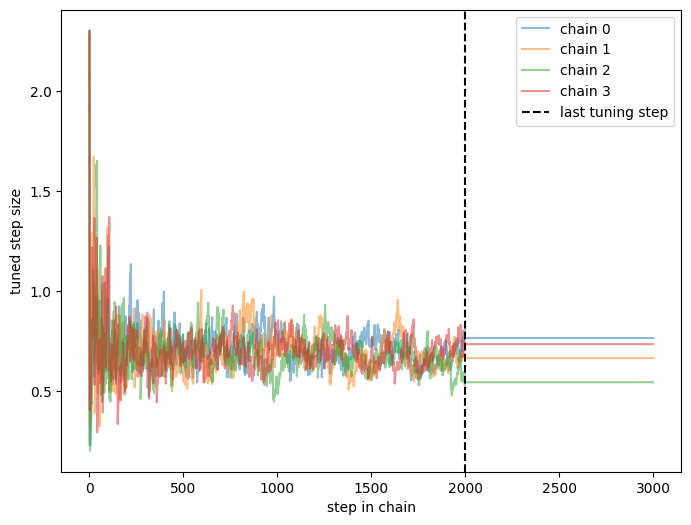

In [7]:
with tamed_devils_funnel:
    trace = pm.sample(
        chains=4, tune=2000, target_accept=0.95, return_inferencedata=False, discard_tuned_samples=False)

plot_trace_step_sizes(trace)

**Task:** Increase the number of tuning steps by setting `tune=2000` when sampling. What difference does this make to the step size tuning results?

In [8]:
# ENTER YOUR ANSWER IN FORUM

**Task:** Increase the target acceptance rate by setting `target_accept=0.95` when sampling. What difference does this make to the step size tuning results? (The default target acceptance rate for the No-U-Turn sampler in PyMC is 0.8.)

In [9]:
# ENTER YOUR ANSWER IN FORUM

**Optional task:** Try this out for other models. Pick your favorite model from previous lessons and visualize the impact of the target acceptance rate on the step size.  You should generally see that increasing the target acceptance rate decreases the step size _for a particular model_. We can't really compare these results between models since each model has its own ideal step size.

### More sampler statistics!

Below we try out different target acceptance rates, ranging from 0.8 (the default) to 0.999 (it has to be less than 1). We visualize the tuned step size for each target acceptance rate as well as the following.

* The actual acceptance rate achieved by the sampler. This should be very similar to the target acceptance rate.
* The average computer time required to produce a sample. This is an important metric since we don't want our sampler to be slow. An appropriately tuned sampler should use as little time as possible to produce (approximately) independent samples from the posterior.

In [10]:
targets = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]
traces = []

for target_accept in targets:
    with tamed_devils_funnel:
        traces.append(pm.sample(target_accept=target_accept, return_inferencedata=False))

Output()

Output()

Output()

Output()

Output()

Output()

Output()

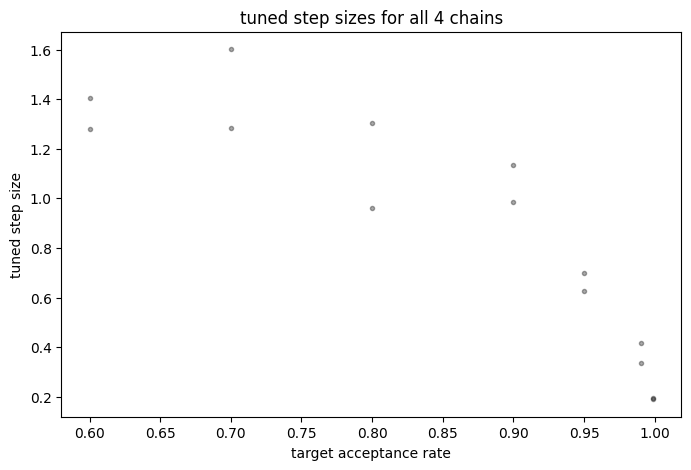

In [11]:
# Plot the tuned step sizes

plt.figure(figsize=(8, 5))
plt.title(f'tuned step sizes for all {trace.nchains} chains')
plt.xlabel('target acceptance rate')
plt.ylabel('tuned step size')
plt.plot(
    targets,
    [trace.get_sampler_stats('step_size')[::1000] for trace in traces],
    'k.', alpha=0.333)
plt.show()

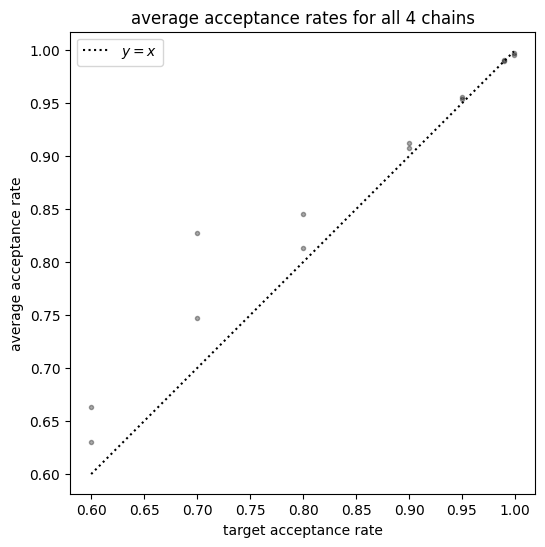

In [12]:
# Plot the actual acceptance rates

plt.figure(figsize=(6, 6))
plt.title(f'average acceptance rates for all {trace.nchains} chains')
plt.xlabel('target acceptance rate')
plt.ylabel('average acceptance rate')
plt.plot(
    targets,
    [trace.get_sampler_stats('mean_tree_accept').reshape((trace.nchains, 1000)).mean(axis=1) for trace in traces],
    'k.', alpha=0.333)
plt.plot(targets, targets, 'k:', label='$y = x$')
plt.legend()
plt.axis('equal')
plt.show()

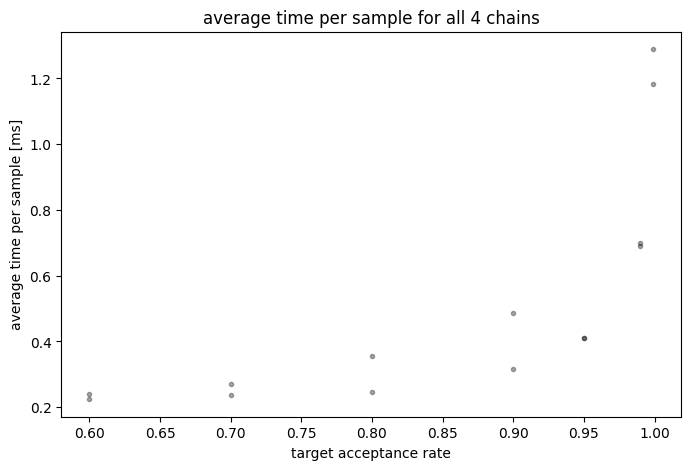

In [13]:
# Plot the time taken (in milliseconds) per sample

plt.figure(figsize=(8, 5))
plt.title(f'average time per sample for all {trace.nchains} chains')
plt.xlabel('target acceptance rate')
plt.ylabel('average time per sample [ms]')
plt.plot(
    targets,
    [trace.get_sampler_stats('process_time_diff').reshape((trace.nchains, 1000)).mean(axis=1) * 1000 for trace in traces],
    'k.', alpha=0.333)
plt.show()

Interpret the results above. How does increasing the target acceptance rate influence the behavior of the sampler in terms of

* the tuned step size,
* the actual acceptance rate,
* the computer time required to generate the samples.

In [14]:
# ENTER YOUR ANSWER IN FORUM

## Divergences

Tuning is important for making the sampler run efficiently and for avoiding some sampling problems. However, there are some problems that cannot be fixed even with perfectly tuned parameters. One such problem is divergences. This section is about finding where divergences are happening in the hope that this can help us fix them.

The bad news is that this is hard. We will make progress on this problem today but we are also pushing up against the boundaries of what is known about sampling efficiently in difficult models. Perhaps someone will soon create better tools or algorithms for automatically correcting sampling problems due to divergences but we are not there yet.

### Readings

Much of what has been written on dealing with divergences has been written by the Stan community rather than the PyMC community. Nevertheless, these two libraries use the same No-U-Turn sampler (but implemented in different programming languages) so you should be able to follow the articles without much trouble.

You should understand that a divergence is almost always caused by problems with the landscape of the posterior, that it happens when the energy (in the form of speed or height) of the Hamiltonian particle changes abruptly in an unexpected way, and that divergences are really bad. They are bad because they result in a collection of samples that do not follow the target distribution. Since we have to discard divergent paths, we are biasing the sample distribution away from the areas of the posterior it should explore but cannot.

* Modrák, M. (2018, February 19). [Taming divergences in Stan models](https://www.martinmodrak.cz/2018/02/19/taming-divergences-in-stan-models/). (2,000 words)

This article provides a practical list of things one can try to find and correct divergences and, more importantly, for now, great visualization and explanation of the types of geometry problems that lead to divergences. Use this article to understand what problematic posterior geometries look like.

* (Optional) Betancourt, M. (2017). [Diagnosing biased inference with divergences](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html). (6,000 words)

This is a case study showing how divergent transitions arise in a hierarchical model (they often show up in hierarchical models) and how we can improve things by reparameterizing the model. The author first shows what happens when we try to improve the sampler by tuning the parameters — it sort of works but not well enough. He then shows how reparameterizing the model drastically improves the sampling behavior.

### Demonstration: The devil's funnel

We already visualized the devil's funnel model. It's repeated below for convenience. Let's also sample from the model — and get lots of divergences.

Model variables: [v, x]


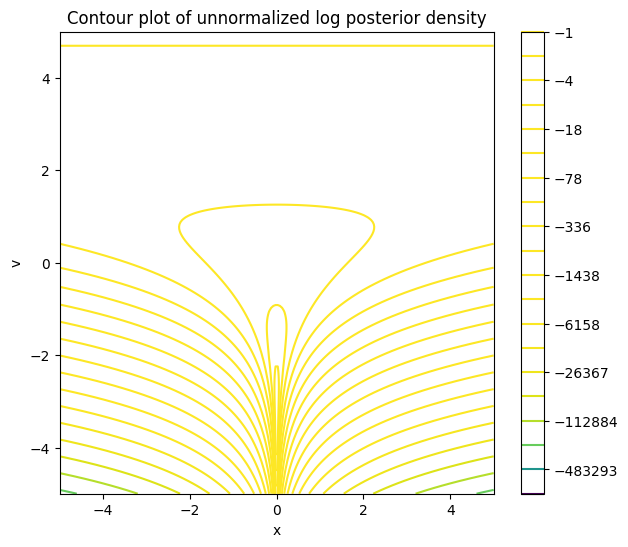

In [15]:
with pm.Model() as devils_funnel:
    v = pm.Normal('v', mu=0, sigma=3)
    x = pm.Normal('x', mu=0, sigma=pm.math.exp(v))

print('Model variables:', devils_funnel.value_vars)

plot_two_parameter_log_posterior(
    devils_funnel, [('x', np.linspace(-5, 5, 200)), ('v', np.linspace(-5, 5, 200))],
    contour_kwargs={'levels': -np.logspace(0, 6, 20)[::-1]})

plt.show()

In [16]:
# Note the new flag in pm.sample(). We use keep_warning_stat=True to ask PyMC
# to keep additional information about divergences, specifically where they
# started so we can debug problems in the model.

with devils_funnel:
    trace = pm.sample(chains=4, return_inferencedata=False, keep_warning_stat=True)

Output()

ERROR:pymc.stats.convergence:There were 345 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Next, we visualize the samples and the divergences. There is a complicated plotting function. It is complicated only because there isn't yet any nice plotting functionality in Arviz or PyMC to do this (but see the sidenote below). Reading through the plotting function below is optional. Interpreting the results is very important.

Sidenote: Arviz does a lot to display divergences in a pair plot _but_ the locations it shows aren't that useful. They are not the locations of where each divergence's Hamiltonian step started and ended but rather the location of the sample that was chosen after the diverging part of the path was discarded. This is not useful for finding the location(s) in the posterior where we have complicated geometry causing divergences. The plotting function below gets the start point of each divergence and visualizes that.

In [17]:
def pairplot_divergences(trace, var1, var2, color='black', divergence_color='red'):
    # Extract the sample values to plot
    var_names = []
    var_indexes = []
    sample_values = []
    for var in [var1, var2]:
        if var.endswith(']'):
            pos = var.find('[')
            assert pos != -1
            index = int(var[pos+1:-1])
            var = var[:pos]
        else:
            index = None
        x = trace.get_values(varname=var, combine=True)
        if index is not None:
            x = x[:, index]
        var_names.append(var)
        var_indexes.append(index)
        sample_values.append(x)

    # Extract the divergence locations to plot
    from collections import defaultdict
    divergent_point = defaultdict(list)
    for warning_ in trace.warning.flat:
        if (
            (warning_ is not None) and
            (warning_.kind == pm.stats.convergence.WarningType.DIVERGENCE) and
            (warning_.divergence_point_source is not None)
        ):
            q = warning_.divergence_point_source
            for var in var_names:
                divergent_point[var].append(q[var])
    divergent_values = []
    for var, index in zip(var_names, var_indexes):
        x = np.asarray(divergent_point[var])
        if (len(x) > 0) and (index is not None):
            x = x[:, index]
        divergent_values.append(x)

    plt.figure(figsize=(6, 6))
    plt.title('scatter plot of samples and divergences')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.plot(*sample_values, '.', color=color, alpha=0.1, label='samples')
    plt.plot(*divergent_values, '.', color=divergence_color, alpha=0.5, label='start of divergences')
    plt.legend()

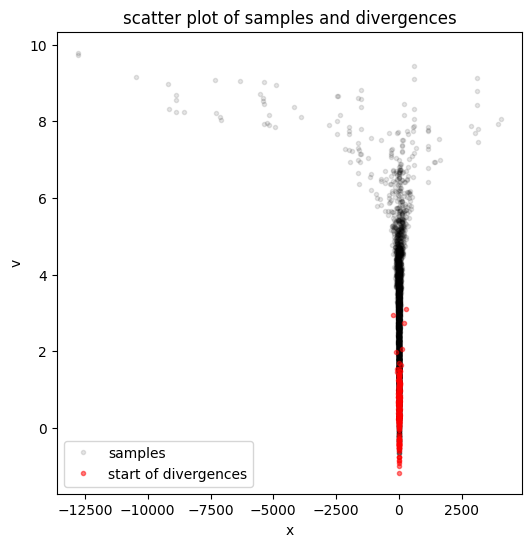

In [18]:
pairplot_divergences(trace, 'x', 'v')

Observations: Firstly, there are lots of divergences. Secondly, they seem to be concentrated in that narrow part of the funnel where we observed the very steep contours of the log-posterior function.

We already know that reparameterizing the distribution removes the funnel and makes the sampler behave much better without changing the mathematical properties of the model.

### The eight schools model

This is the same model as in the Betancourt reading, written in PyMC rather than Stan.

In [19]:
# Data of the eight schools model
data_y = np.array([28, 8, -3, 7, -1, 1, 18, 12], dtype=float)
data_sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype=float)

# The problematic model
with pm.Model() as eight_schools:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=len(data_y))
    observed = pm.Normal('observed', mu=theta, sigma=data_sigma, observed=data_y)

# The reparameterized model
with pm.Model() as tamed_eight_schools:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)

    # These two lines are different and implement the centered
    # transformation of `theta` using `phi`
    phi = pm.Normal('phi', mu=0, sigma=1, shape=len(data_y))
    theta = pm.Deterministic('theta', phi * tau + mu)

    observed = pm.Normal('observed', mu=theta, sigma=data_sigma, observed=data_y)

In [20]:
with eight_schools:
    trace = pm.sample(chains=4, return_inferencedata=False, keep_warning_stat=True)

Output()

ERROR:pymc.stats.convergence:There were 282 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Before we plot the parameters, you should note the variables used in the PyMC model.

In [21]:
eight_schools.value_vars

[mu, tau_log__, theta]

The `mu` and `theta` variables should be familiar. But notice how there is a `tau_log__` variable instead of the `tau` variable. This is because $\tau > 0$ and the Hamiltonian sampler requires unconstrained real values for its parameters. To get from a positive value to an unconstrained value, the sampler samples values of $\log \tau$ and transforms them back to $\tau$ later using the exponential function.

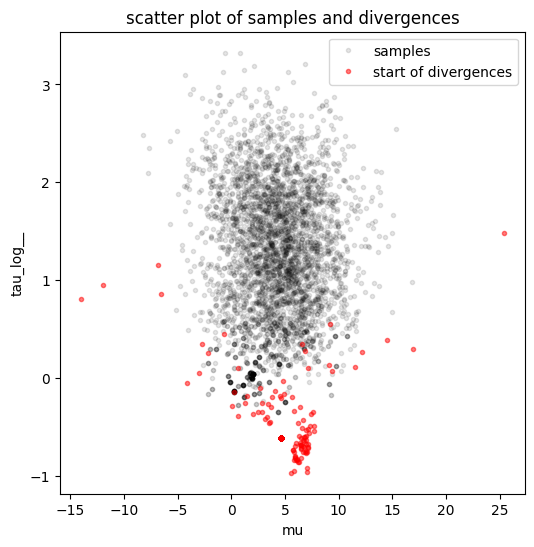

In [22]:
pairplot_divergences(trace, 'mu', 'tau_log__')

Observations: The divergences are mostly near the bottom in a geometry reminiscent of the devil's funnel. Let's visualize the funnel using a contour plot.

Eight schools model variables: [mu, tau_log__, theta]


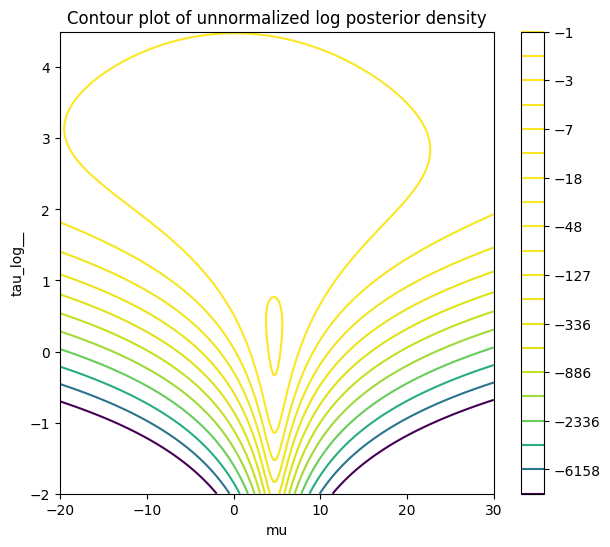

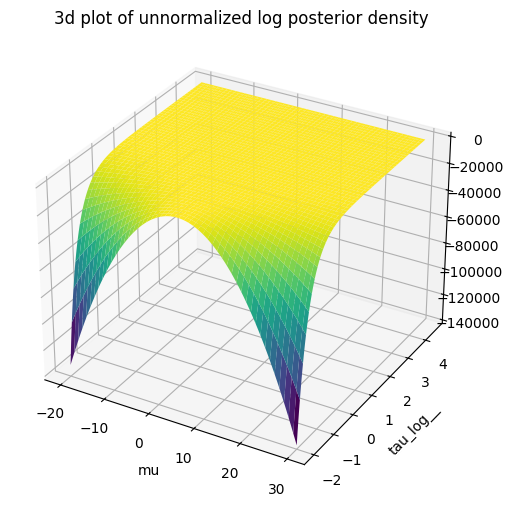

In [23]:
print('Eight schools model variables:', eight_schools.value_vars)

plot_two_parameter_log_posterior(
    eight_schools,
    [
        ('mu', np.linspace(-20, 30, 200)),
        ('tau_log__', np.linspace(-2, 4.5, 200))],
    fixed_params={
        'theta': trace.get_values('theta').mean(axis=0)},
    contour_kwargs={'levels': -np.logspace(0, 4, 20)[::-1]},
    plot_kind='both')

plt.show()

The centered parameterization helps a lot:

In [24]:
with tamed_eight_schools:
    trace = pm.sample(chains=4, target_accept=0.99, return_inferencedata=False, keep_warning_stat=True)

Output()

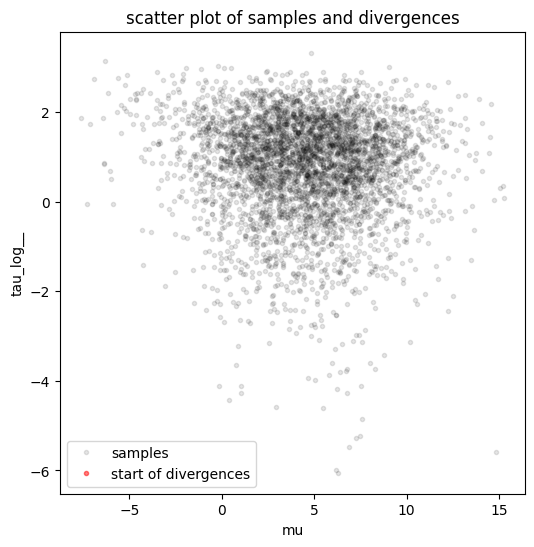

In [25]:
pairplot_divergences(trace, 'mu', 'tau_log__')

Reparameterized eight schools model variables: [mu, tau_log__, phi]


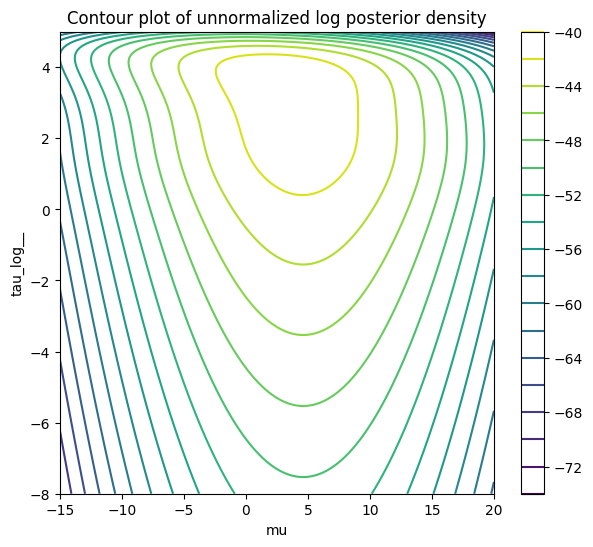

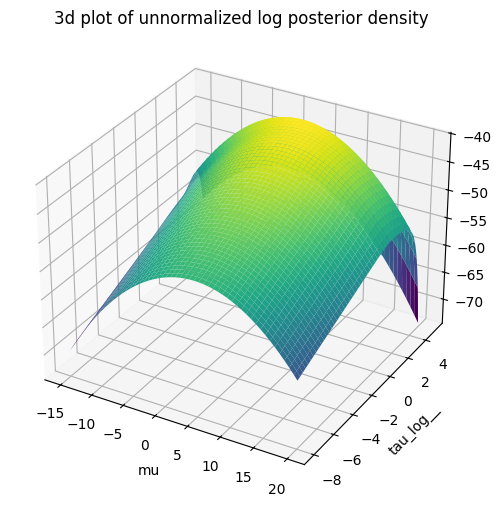

In [26]:
print('Reparameterized eight schools model variables:', tamed_eight_schools.value_vars)

plot_two_parameter_log_posterior(
    tamed_eight_schools,
    [
        ('mu', np.linspace(-15, 20, 200)),
        ('tau_log__', np.linspace(-8, 5, 200))],
    fixed_params={
        'phi': trace.get_values('phi').mean(axis=0)},
    contour_kwargs={'levels': 20}, plot_kind='both')

plt.show()

## Task: Fix the chimpanzee model

This is a model we have seen before — where an experiment measures the prosocial behavior of chimpanzees by monitoring which lever they pull. Use the tools we have to identify and fix the problems with the geometry of this distribution.

[a_bar, sigma_a_log__, sigma_g_log__, a_rec, g_rec, b]


Output()

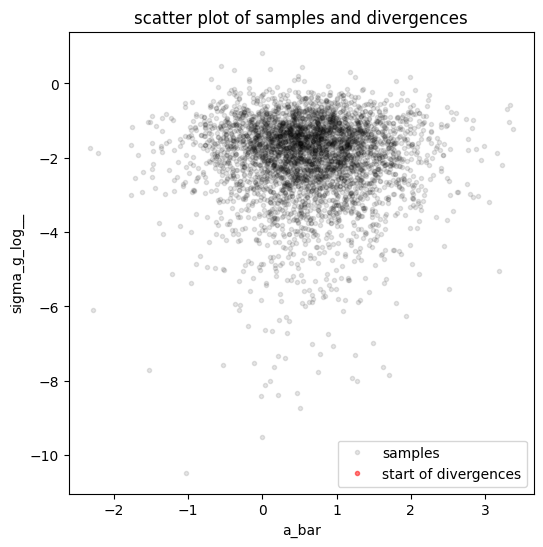

In [34]:
# Load and pre-process the data
df = pd.read_csv(
    'https://course-resources.minerva.edu/uploaded_files/mu/00273678-4926/chimpanzee.csv',
    sep=';')
treatment = (df.prosoc_left + 2 * df.condition).values
Ntreatments = len(np.unique(treatment))
actor = (df.actor - 1).astype(int).values
Nactor = len(np.unique(actor))
block = (df.block - 1).astype(int).values
Nblock = len(np.unique(block))

with pm.Model() as chimpanzee_model:
    # hyper-priors
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    sigma_a = pm.Exponential('sigma_a', lam=1)
    sigma_g = pm.Exponential('sigma_g', lam=1)

    # adaptive priors
    a_rec = pm.Normal('a_rec', shape=Nactor, mu=0, sigma=1)
    a = pm.Deterministic('a', a_bar + a_rec * sigma_a)

    g_rec = pm.Normal('g_rec', shape=Nblock, mu=0, sigma=1)
    g = pm.Deterministic('g', g_rec * sigma_g)

    b = pm.Normal('b', shape=Ntreatments, mu=0, sigma=0.5)
    p = pm.math.invlogit(a[actor] + g[block] + b[treatment])

    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df.pulled_left)

print(chimpanzee_model.value_vars)
with chimpanzee_model:
    trace = pm.sample(2000, target_accept=0.99, return_inferencedata=False, keep_warning_stat=True)

pairplot_divergences(trace, var1='a_bar', var2='sigma_g_log__')

In [28]:
# YOUR WORK GOES HERE; PASTE YOUR CODE INTO FORUM

Describe how you fixed the model.

In [29]:
# ENTER YOUR ANSWER IN FORUM

## Optional task: Fix the Cauchy model

This hierarchical model predicts the survival rate of frogs in various tanks. Use the tools we have to identify and fix the problems with the geometry of this distribution. This model is particularly challenging because of the Cauchy prior but perhaps you can find a way to fix it (without changing the prior!)

In [30]:
# Load the data
data = pd.read_csv(
    'https://course-resources.minerva.edu/uploaded_files/mu/00292851-6231/reedfrogs.csv')
# Make the tank cluster variable
data.insert(0, 'tank', np.arange(data.shape[0]))

n_tanks = data.shape[0]

with pm.Model() as cauchy_model:
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Normal('mu', mu=0, sigma=1)

    a = pm.Cauchy('a', shape=n_tanks, alpha=mu, beta=sigma)

    p = pm.math.invlogit(a[data.tank])
    S = pm.Binomial('S', n=data.density, p=p, observed=data.surv)

print(cauchy_model.value_vars)
with cauchy_model:
    trace = pm.sample(2000, chains=4, return_inferencedata=False, keep_warning_stat=True)

pairplot_divergences(trace, var1='a[1]', var2='sigma_log__')

with cauchy_model:
    display(az.summary(pm.to_inference_data(trace)))

[sigma_log__, mu, a]


Output()

ValueError: Not enough samples to build a trace.

In [ ]:
# YOUR WORK GOES HERE; PASTE YOUR CODE INTO FORUM